# Resize Images from google images to 256x256

In [1]:
# import os 
# import numpy as np
# import cv2

# downloadsdir = './downloads'
# dirs = [x for x in os.walk(downloadsdir)]
# for shroom in dirs[0][1]:
#     resizeddir = './resized\\\\'+shroom
#     fullsizedir = './downloads\\\\'+shroom
#     if not os.path.exists(resizeddir):
#         os.makedirs(resizeddir)
#     pics = [x[2] for x in os.walk(fullsizedir)]
#     for idx, p in enumerate(pics[0]):
#         if not p.endswith('.gif'):
#             picpath = fullsizedir+'\\\\'+p
#             try:
#                 img = cv2.imread(picpath,-1)
#                 resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
#                 cv2.imwrite(resizeddir+'\\\\'+str(idx)+'.jpg', resized)
#             except:
#                 print('Could not process ' + p)


In [2]:
import pandas as pd
import numpy as np
import os
import cv2

num_classes = 16

X = []
y = []
# is_edible = []

# mushroom_info = pd.read_json('mushroom_classes.json', lines=True)
classdirs = [x for x in os.walk('./resized')]
for shroomidx, shroom in enumerate(classdirs[0][1]):
#     info = mushroom_info.loc[mushroom_info.name_latin == shroom]
#     edible = info.edibility.isin(("edible", "edible and good", "edible and excellent"))
#     is_edible.append(edible)
    imagepaths = [x for x in os.walk('./resized\\\\'+shroom)]
    for path in imagepaths[0][2]:
        img = cv2.imread('./resized\\\\'+shroom+'\\\\'+path,-1)
        if (img.shape == (224, 224, 3)):
            X.append(img)
            y.append(shroomidx)

X = np.stack(X)
y = np.stack(y)
# is_edible = pd.Series(is_edible)
print(X.shape)
print(y.shape)
# print(is_edible.shape)
    

(1090, 224, 224, 3)
(1090,)


In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator()

C:\Users\Kevin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Train and test data
import keras
# rescale !!
X = X/255.0

N = len(X)
N_tr = int(0.8*N)

# shuffle the data
indx = np.arange(N)
np.random.shuffle(indx)
X = X[indx]
y = y[indx]

# split
X_tr = X[0:N_tr]
y_tr = y[0:N_tr]
y_tr = keras.utils.to_categorical(y_tr, num_classes)

X_te = X[N_tr:]
y_te = y[N_tr:]
y_te = keras.utils.to_categorical(y_te, num_classes)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

# def my_model():
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=X[0].shape))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.4))
#     model.add(Dense(len(is_edible), activation='sigmoid'))
#     return model



In [6]:
# model = my_model()


from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

basemodel = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))
for layer in basemodel.layers[1:13]:
    layer.trainable = False
    
topmodel = Sequential()
topmodel.add(Flatten(input_shape=basemodel.output_shape[1:]))
topmodel.add(Dense(num_classes, activation='relu'))
topmodel.add(Dropout(0.4))
topmodel.add(Dense(num_classes, activation='sigmoid'))

model = Model(inputs = basemodel.input, outputs = topmodel(basemodel.output))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)


In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
# fits the model on batches with real-time data augmentation:
N_BATCH = 8

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.45,
                              patience=5,
                              min_lr=0.001)
history = model.fit(X_tr, y_tr,
                    batch_size = N_BATCH,
                    epochs = 200,
                    verbose = 1,
                    validation_data = (X_te, y_te),
                    callbacks=[reduce_lr])

# save model weights and training history
model.save_weights('models/weights.h5')
import pickle
with open('models/history', 'wb') as f:
        pickle.dump(history.history, f)

Train on 872 samples, validate on 218 samples
Epoch 1/200
872/872 [==============================] - 21s 24ms/step - loss: 2.8127 - acc: 0.0562 - val_loss: 2.7728 - val_acc: 0.0505
Epoch 2/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7745 - acc: 0.0791 - val_loss: 2.7664 - val_acc: 0.0505
Epoch 3/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7711 - acc: 0.0837 - val_loss: 2.7733 - val_acc: 0.0505
Epoch 4/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7700 - acc: 0.0803 - val_loss: 2.7735 - val_acc: 0.0505
Epoch 5/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7699 - acc: 0.0814 - val_loss: 2.7737 - val_acc: 0.0505
Epoch 6/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7699 - acc: 0.0814 - val_loss: 2.7740 - val_acc: 0.0505
Epoch 7/200
872/872 [==============================] - 19s 22ms/step - loss: 2.7677 - acc: 0.0837 - val_loss: 2.7742 - val_acc: 0.0505
Epoch 8/2

Epoch 61/200
872/872 [==============================] - 19s 22ms/step - loss: 0.3048 - acc: 0.8922 - val_loss: 0.9590 - val_acc: 0.8073
Epoch 62/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2955 - acc: 0.8968 - val_loss: 0.9466 - val_acc: 0.8073
Epoch 63/200
872/872 [==============================] - 19s 22ms/step - loss: 0.3183 - acc: 0.8830 - val_loss: 0.9351 - val_acc: 0.7936
Epoch 64/200
872/872 [==============================] - 19s 22ms/step - loss: 0.3236 - acc: 0.8773 - val_loss: 0.8554 - val_acc: 0.8349
Epoch 65/200
872/872 [==============================] - 19s 22ms/step - loss: 0.3145 - acc: 0.8819 - val_loss: 0.8196 - val_acc: 0.8349
Epoch 66/200
872/872 [==============================] - 19s 22ms/step - loss: 0.3361 - acc: 0.8612 - val_loss: 0.8918 - val_acc: 0.8165
Epoch 67/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2955 - acc: 0.8888 - val_loss: 0.9356 - val_acc: 0.8165
Epoch 68/200
872/872 [==========================

872/872 [==============================] - 19s 22ms/step - loss: 0.2482 - acc: 0.9014 - val_loss: 1.1318 - val_acc: 0.8073
Epoch 122/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2251 - acc: 0.9037 - val_loss: 0.9855 - val_acc: 0.8211
Epoch 123/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2218 - acc: 0.9163 - val_loss: 1.0204 - val_acc: 0.8303
Epoch 124/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2528 - acc: 0.9048 - val_loss: 1.0185 - val_acc: 0.8165
Epoch 125/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2486 - acc: 0.8991 - val_loss: 0.9606 - val_acc: 0.8119
Epoch 126/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2472 - acc: 0.9014 - val_loss: 0.9788 - val_acc: 0.8349
Epoch 127/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2439 - acc: 0.8899 - val_loss: 0.9294 - val_acc: 0.8257
Epoch 128/200
872/872 [==============================] 

Epoch 181/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2004 - acc: 0.9220 - val_loss: 1.0020 - val_acc: 0.8165
Epoch 182/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2058 - acc: 0.9186 - val_loss: 1.0539 - val_acc: 0.8165
Epoch 183/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2074 - acc: 0.9209 - val_loss: 1.0905 - val_acc: 0.8073
Epoch 184/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2121 - acc: 0.9174 - val_loss: 0.9860 - val_acc: 0.8349
Epoch 185/200
872/872 [==============================] - 19s 22ms/step - loss: 0.1913 - acc: 0.9278 - val_loss: 1.0242 - val_acc: 0.8303
Epoch 186/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2333 - acc: 0.9128 - val_loss: 1.0828 - val_acc: 0.8211
Epoch 187/200
872/872 [==============================] - 19s 22ms/step - loss: 0.2024 - acc: 0.9243 - val_loss: 1.0490 - val_acc: 0.8257
Epoch 188/200
872/872 [==================

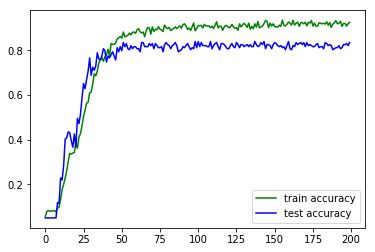

In [11]:
# load the model training history
import matplotlib.pyplot as plt
with open("models/history", "rb") as f:
    hist = pickle.load(f)
    
plt.plot(hist["acc"], label = "train accuracy", color = "green")
plt.plot(hist["val_acc"], label = "test accuracy", color = "blue")
plt.legend()
plt.savefig("docs/training_history.png")
plt.show()

In [12]:

model.save("./models/vgg16pretrained.h5")
# def predict_and_draw(i, X, y, model, classnames, save = False):
#     x = X[i]
#     x = x.astype(np.uint8)
#     plt.imshow(x)
#     x = x/ 255.0
#     x.shape = (1, ) + x.shape
#     p = model.predict(x)[0,0].round(2)
#     plt.title("P(edible): " + str(p) + " Actually edible: " + str(y[i]))
#     if(save):
#         plt.savefig("docs/prediction_"+str(i)+".png")
#     plt.show()
    
# draw_sample(1, X, y, classdirs[0][1])
